In [ ]:
import scanpy as sc
import numpy as np
import os

from gene_trajectory.add_gene_bin_score import add_gene_bin_score
from gene_trajectory.coarse_grain import select_top_genes, coarse_grain_adata
from gene_trajectory.extract_gene_trajectory import get_gene_embedding, extract_gene_trajectory
from gene_trajectory.get_graph_distance import get_graph_distance
from gene_trajectory.gene_distance_shared import cal_ot_mat
from gene_trajectory.run_dm import run_dm
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_3d, plot_gene_trajectory_umap
from gene_trajectory.util.download_file import download_file_if_missing

2025-05-05 09:23:12.480081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746451392.498256   20647 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746451392.503703   20647 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### tutorial data

In [3]:
adata = sc.read_h5ad('/data/peer/chene5/_hd_stats/tutorial_data/human_myeloid_scanpy_obj.h5ad')

In [4]:
if 'counts' not in adata.layers:
    adata.layers['counts'] = adata.raw.X.copy()
genes = select_top_genes(adata, layer='counts', n_variable_genes=500) ### these are the top genes that are selected and used

In [16]:
# filter down to top genes
select_adata = adata[:, genes].copy()
X = select_adata.layers['counts'].todense()

In [ ]:
# gene covariance matrix
gene_cov_mat = np.cov(X.T)

# dist matrix by inversion
gene_dist_mat = 1 - gene_cov_mat

Early stop reached. 0 gene trajectories were retrieved.


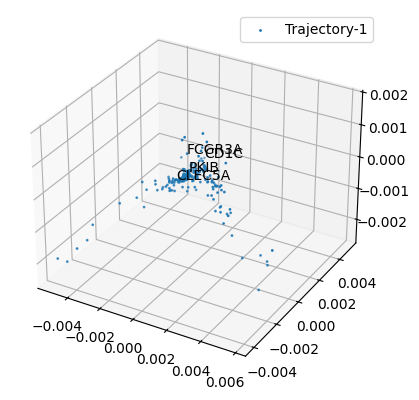

In [ ]:
gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)
gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, t_list = [4, 8, 7], gene_names=genes, k=5)

plot_gene_trajectory_3d(gene_trajectory, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])


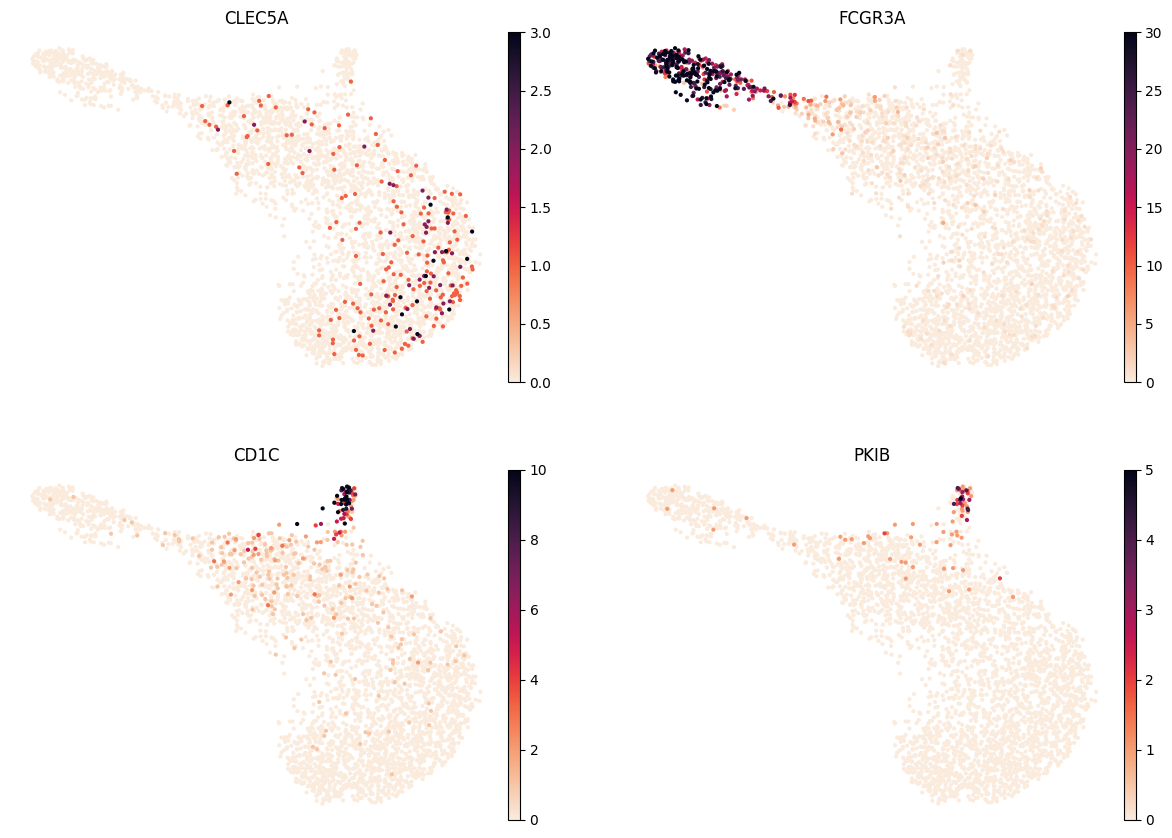

In [109]:
sc.pl.umap(adata, color=['CLEC5A', 'FCGR3A', 'CD1C', 'PKIB'], vmax=[3, 30, 10,  5,], vmin=[0, 0, 0, 0], frameon=False, cmap='rocket_r', ncols=2)

In [39]:
# sort by DM_1
gene_trajectory.sort_values(by='DM_1', ascending=True)

DM_1      DM_2      DM_3      DM_4      DM_5      selected  \
CXCL8   -0.005059 -0.004073 -0.001912  0.000015  0.000176  Trajectory-1   
CES1    -0.004577 -0.003938 -0.001975  0.000697  0.000846  Trajectory-1   
PADI4   -0.003977 -0.003884 -0.001485  0.001779  0.001528  Trajectory-1   
ALOX5AP -0.003903 -0.002699 -0.001114  0.001309  0.000587  Trajectory-1   
RETN    -0.003877 -0.003201 -0.001430  0.000700  0.000730  Trajectory-1   
...           ...       ...       ...       ...       ...           ...   
IFI30    0.004144  0.000253 -0.001776  0.000011 -0.000054  Trajectory-1   
EVL      0.004539  0.000246 -0.001906  0.000460  0.000272  Trajectory-1   
MTSS1    0.004673 -0.000697 -0.002464  0.000507 -0.000551  Trajectory-1   
ABI3     0.004798 -0.000119 -0.001858  0.000107  0.000080  Trajectory-1   
TCF7L2   0.005781 -0.001274 -0.000850  0.000410 -0.000184  Trajectory-1   

         Pseudoorder-1  
CXCL8            250.0  
CES1             241.0  
PADI4            237.0  
ALOX5AP          242.0  
RETN             240.0  
...                ...  
IFI30             16.0  
EVL               27.0  
MTSS1              8.0  
ABI3              26.0  
TCF7L2             1.0  

[251 rows x 7 columns]

In [ ]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['TCF7L2', 'ABI3', 'MTSS1', 'EVL'])


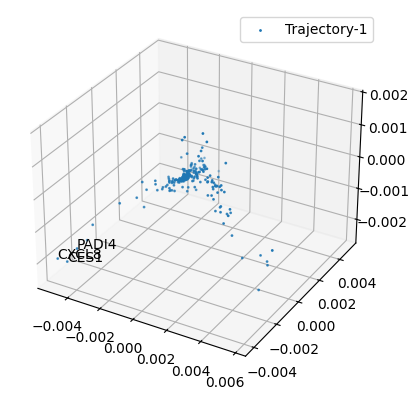

In [ ]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['CXCL8', 'CES1', 'PADI4'])


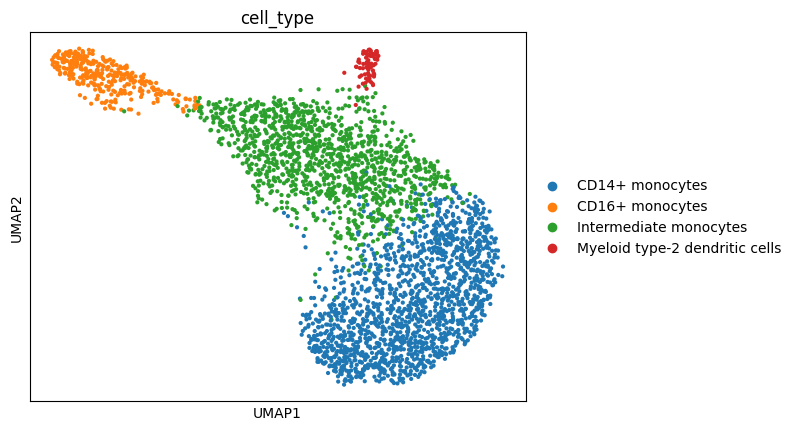

In [44]:
adata.obs['cell_type'] = adata.obs['cluster'].replace({
  0: "CD14+ monocytes",
  1: "Intermediate monocytes",
  2: "CD16+ monocytes",
  3: "Myeloid type-2 dendritic cells"}
)
sc.pl.umap(adata, color=["cell_type"])

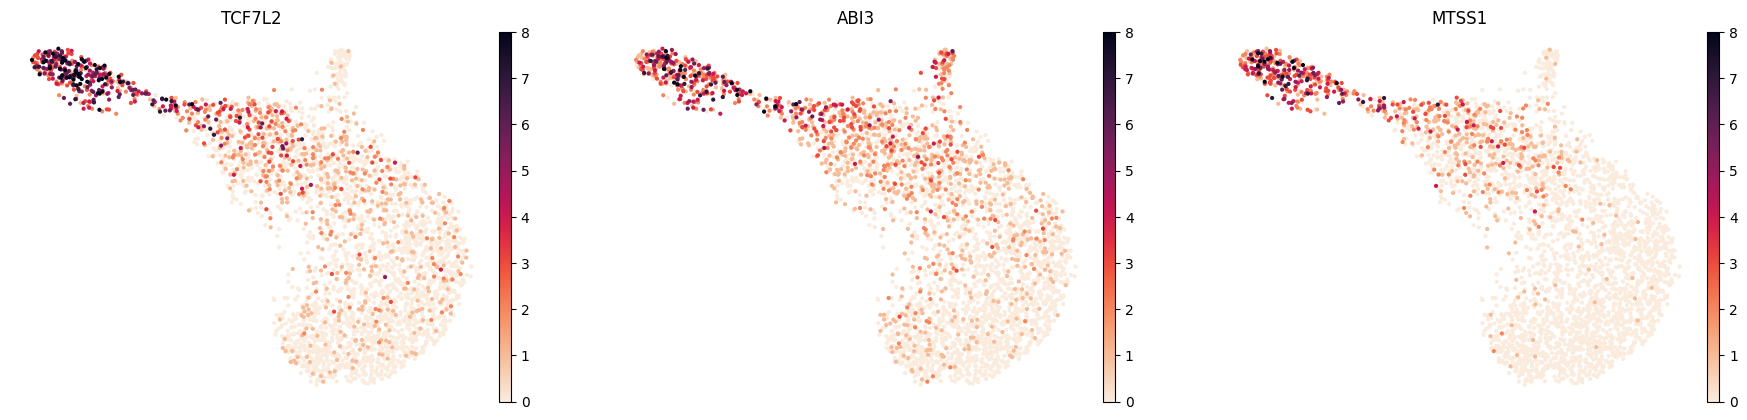

In [112]:
sc.pl.umap(adata, color=['TCF7L2', 'ABI3', 'MTSS1'], vmax=8, frameon=False, cmap='rocket_r',)

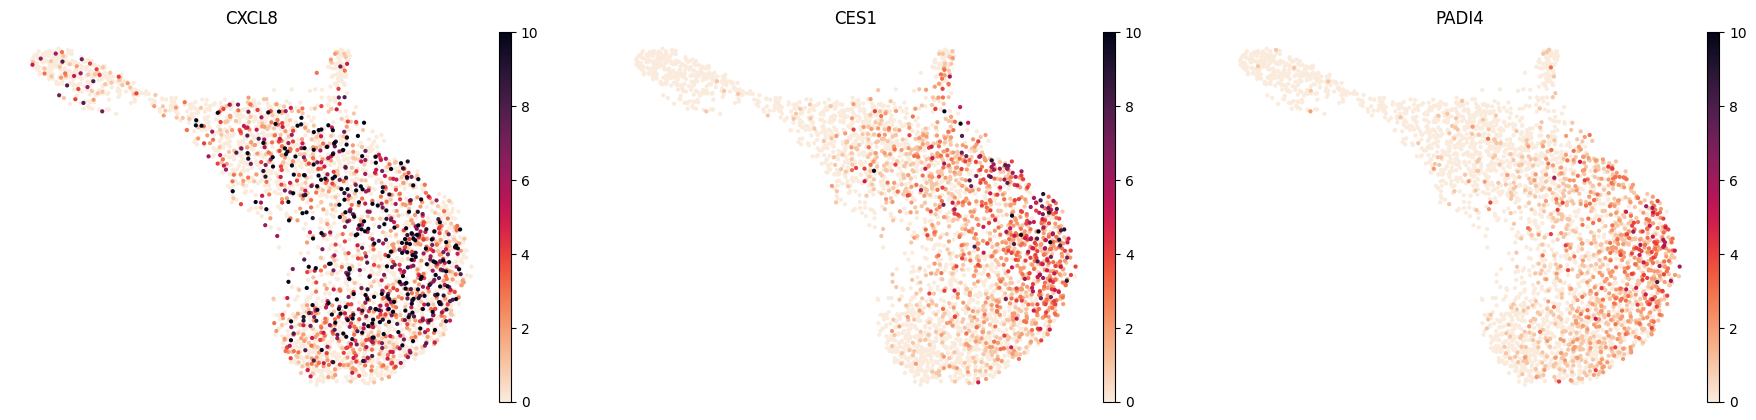

In [113]:
sc.pl.umap(adata, color=['CXCL8', 'CES1', 'PADI4'], vmax=10, frameon=False, cmap='rocket_r',)

### our dataset

In [53]:
import os
import muon as mu

processed_mudata_path = "/data/peer/chene5/_hd_stats/pbmc10k.h5mu" # <<<=== SET PATH TO YOUR PROCESSED h5mu FILE
target_celltypes = ['CD14 mono', 'intermediate mono', 'mDC', 'CD16 mono']
if not os.path.exists(processed_mudata_path):
    raise FileNotFoundError(f"Processed MuData file not found at {processed_mudata_path}")
mdata = mu.read(processed_mudata_path)

In [61]:
rna_filt_mask = mdata.mod['rna'].obs['celltype'].isin(target_celltypes)
rna_filt = mdata.mod['rna'][rna_filt_mask].copy()

In [55]:
rna_filt

AnnData object with n_obs × n_vars = 3498 × 26349
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [62]:
if 'counts' not in rna_filt.layers:
    rna_filt.layers['counts'] = rna_filt.raw.X.copy()

# filter down to top genes
select_adata = rna_filt[:, genes].copy()
X = select_adata.layers['counts'].todense()

In [ ]:
# gene covariance matrix
gene_cov_mat = np.cov(X.T)

# dist matrix by inversion
gene_dist_mat = 1 - gene_cov_mat

# get traj
gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)
gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, t_list = [4, 8, 7], gene_names=genes, k=5)


In [122]:
temp = gene_trajectory['DM_1'].copy()
gene_trajectory['DM_1'] = gene_trajectory['DM_3']
gene_trajectory['DM_3'] = temp

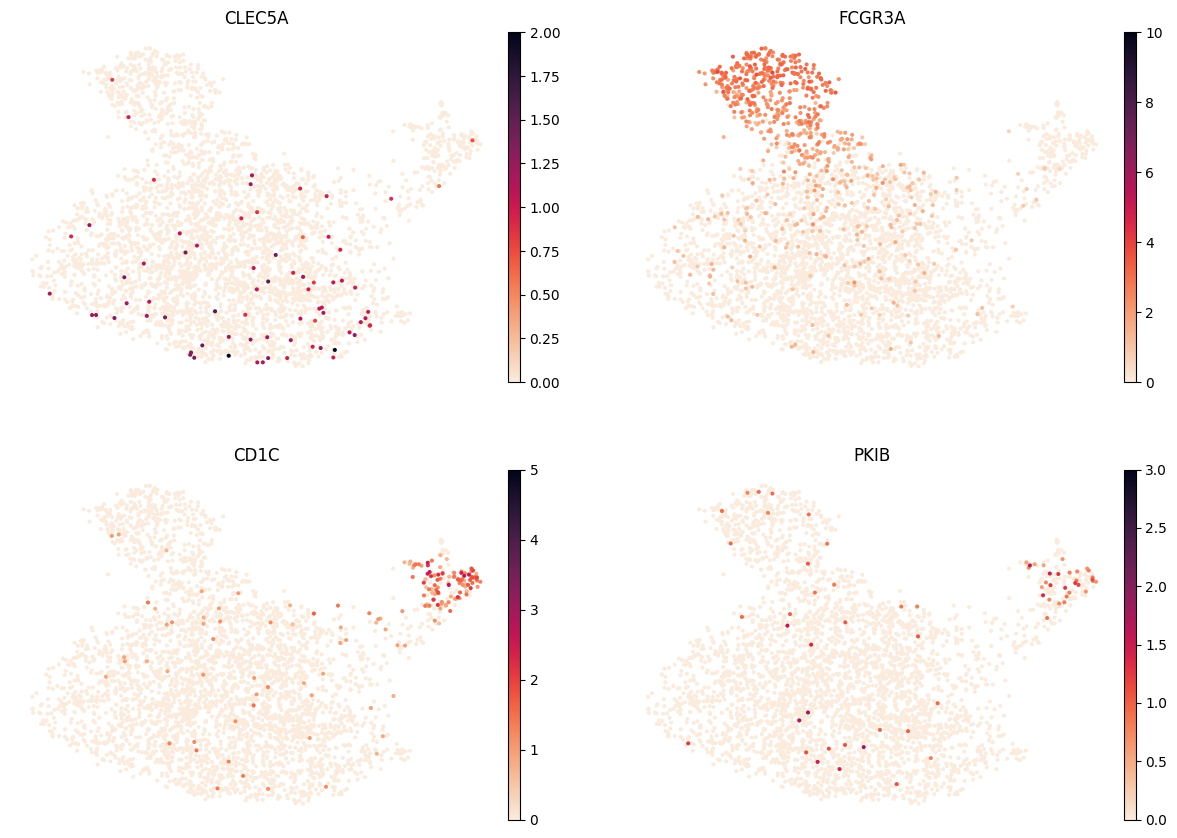

In [128]:
sc.pl.umap(rna_filt, color=['CLEC5A', 'FCGR3A', 'CD1C', 'PKIB'], vmax=[2, 10, 5, 3], vmin=[0, 0, 0, 0], frameon=False, cmap='rocket_r', ncols=2)

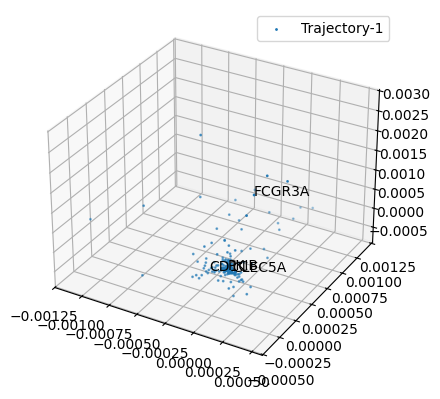

In [123]:

plot_gene_trajectory_3d(gene_trajectory, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])


In [79]:
# sort by DM_1
gene_trajectory.sort_values(by='DM_1', ascending=True).index

Index(['AHR', 'NRG1', 'ATF3', 'PID1', 'PADI4', 'ANKRD28', 'RGCC', 'AFF3',
       'LMNA', 'F13A1',
       ...
       'MT2A', 'GBP4', 'PAG1', 'LY6E', 'IFI30', 'CDKN1C', 'TCF7L2', 'FCGR3A',
       'MTSS1', 'IFITM3'],
      dtype='object', length=251)

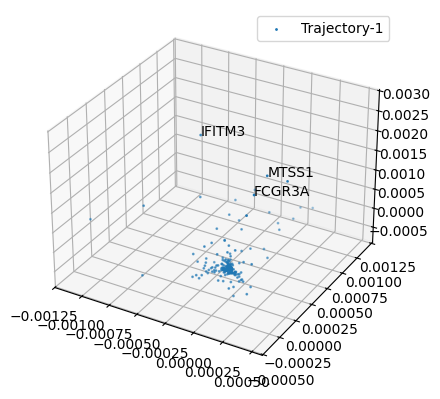

In [130]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['IFITM3', 'MTSS1', 'FCGR3A'])


In [ ]:
# rna_filt.obsm['X_umap'][:,1] = -rna_filt.obsm['X_umap'][:,1]
# rna_filt.obsm['X_umap'][:,0] = -rna_filt.obsm['X_umap'][:,0]


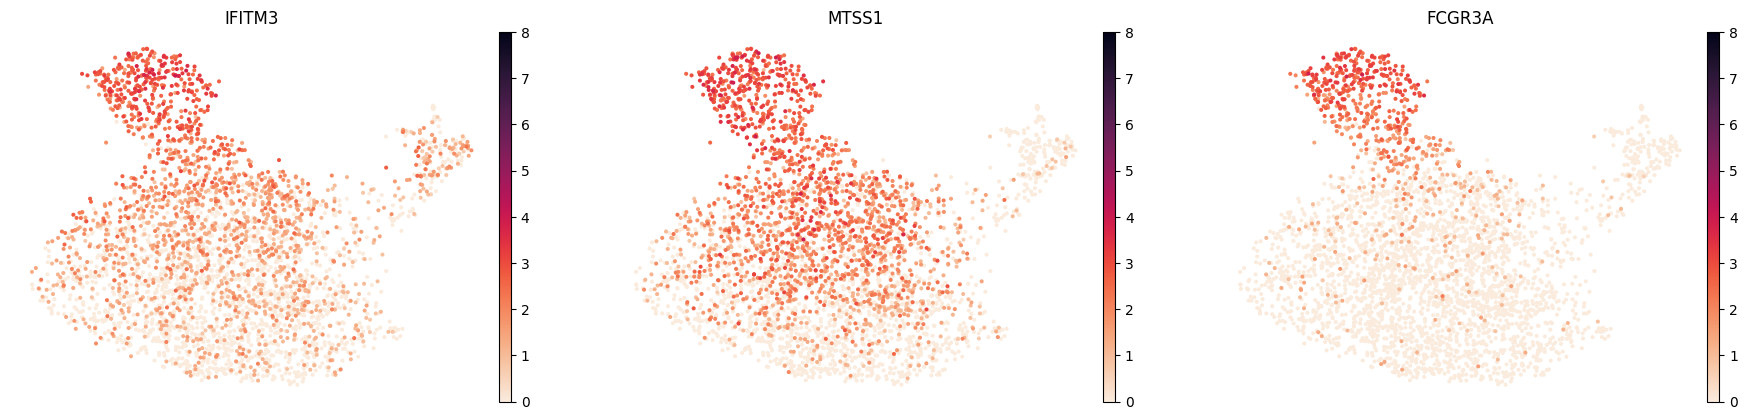

In [121]:
sc.pl.umap(rna_filt, color=[ 'IFITM3', 'MTSS1', 'FCGR3A'], vmax=8, 
 frameon=False, cmap='rocket_r',)

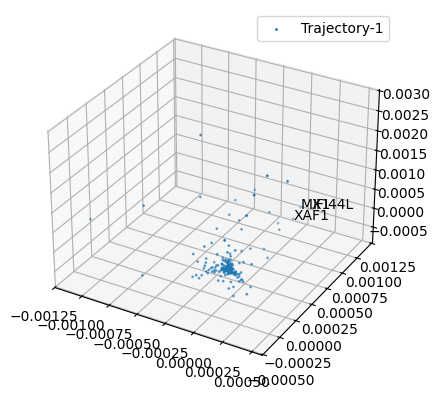

In [129]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['IFI44L', 'MX1', 'XAF1'])


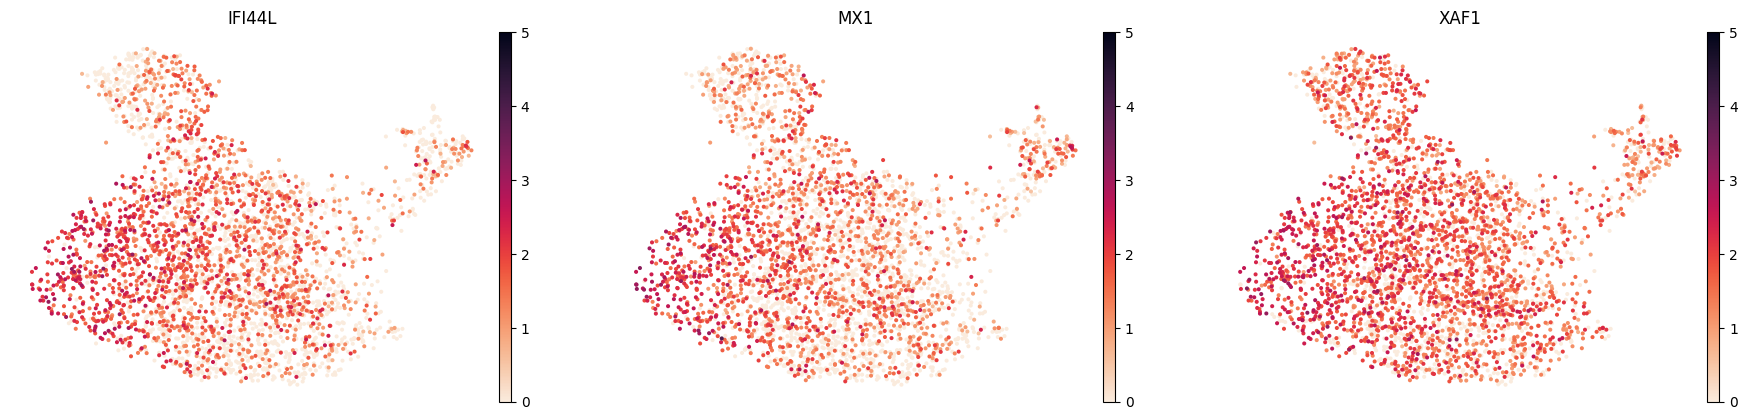

In [131]:
sc.pl.umap(rna_filt, color=['IFI44L', 'MX1', 'XAF1'], vmax=5,
 frameon=False, cmap='rocket_r',)

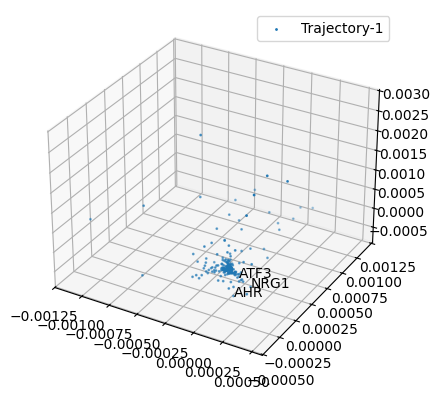

In [132]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['AHR', 'NRG1', 'ATF3'])


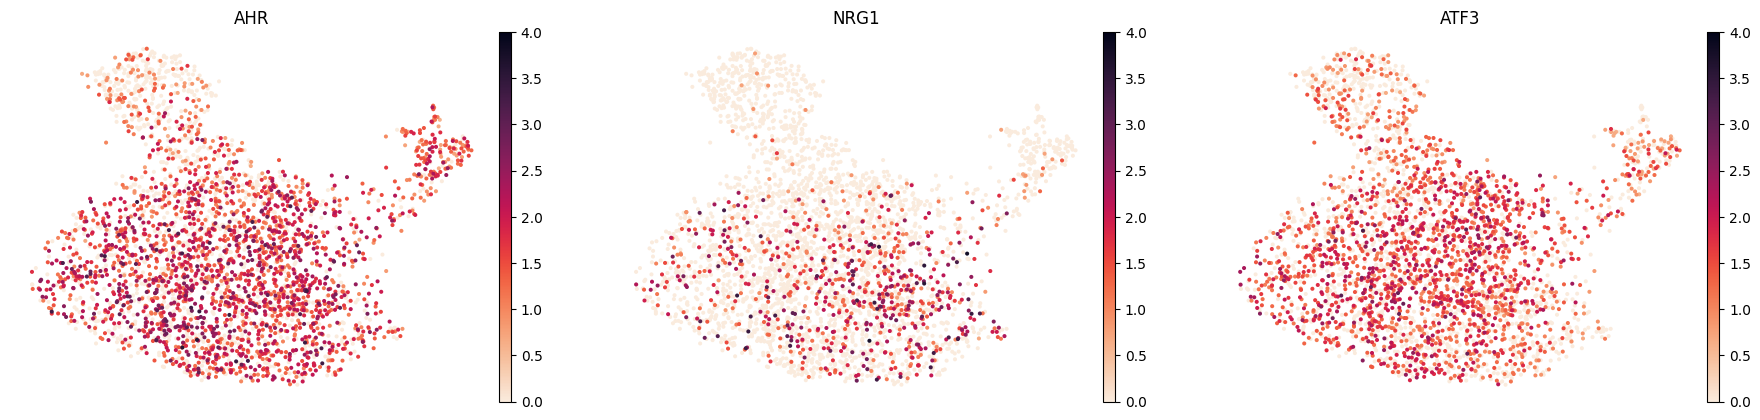

In [133]:
sc.pl.umap(rna_filt, color=['AHR', 'NRG1', 'ATF3'], vmax=4,
 frameon=False, cmap='rocket_r',)